Models: deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B

Colab Environment: GPU T4.

Keys:

Pruning
Structured pruning
Depth pruning.


Let's take a look at an example of depth pruning, where we remove entire layers from the model.

The first thing I noticed when trying this approach was how drastically it impacted the model's performance. Unlike pruning individual neurons from MLP layers—something we explored in the previous example—removing entire layers fundamentally alters the model's architecture.

Because of this, the pruned model isn't immediately usable. Instead, it requires a fine-tuning process to regain its capabilities. This step is crucial to help the model adapt and recover after such a significant structural change.

In [1]:
!pip install -q transformers==4.47.1
!pip install -q datasets==3.2.0
!pip install -q torch==2.5.1
!pip install -q lm-eval==0.4.7

#
import logging
import math
import os
import sys
import shutil
from copy import deepcopy
import torch.nn as nn
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [2]:
#Loading Base model for pruning
from transformers import AutoTokenizer, AutoModelForCausalLM
model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [3]:
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [4]:
# Support function to check the size reduction.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [5]:
def get_ouput(prompt, model=model, tokenizer=tokenizer):
  inputs = tokenizer(prompt, return_tensors='pt').to(device)
  outputs = model.generate(inputs['input_ids'],
                           attention_mask=inputs['attention_mask'])
  generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
  return generated

in this notebook, we’re going to fine-tune the pruning process for the DeepSeek-R1-Distill-Qwen-1.5B.

In [6]:
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qw

In [7]:
print(model.config)

Qwen2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "max_position_embeddings": 131072,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 12,
  "num_hidden_layers": 28,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000,
  "sliding_window": null,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.47.1",
  "use_cache": true,
  "use_mrope": false,
  "use_sliding_window": false,
  "vocab_size": 151936
}



In [8]:
#Testing the original model with a simple prompt
prompt = "what is transformers"
generated = get_ouput(prompt)
print(f"Generated text: {generated}")

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Generated text: what is transformers?
</think>

Transformers are a type of artificial intelligence (AI) model that have revolutionized the


In [9]:
#Print the size of the original model
original_param_count = count_parameters(model)
print(f"Original model parameters: {original_param_count}")

Original model parameters: 1777088000


Support pruning functions.
Here are three differeten methods I used to calculate wich layers to mantain.

The function prune_layers calculates the weight magnitude of each layer to remove those that, in principle, should contribute less to the model.

The other two functions focus on removing either the initial layers or the final layers.

The results obtained with 20% pruning using each method have been quite different.
.

In a Transformer model like this, layers are organized hierarchically: the initial layers (closer to the input) tend to capture basic language patterns (such as syntactic structure, common word combinations, etc.), while the intermediate and final layers refine these representations, capturing higher-order relationships, global coherence, and subtle semantic nuances.

Removing the initial layers directly undermines the foundation upon which more complex representations are built, leading the model to generate meaningless text sequences. Similarly, removing layers based on weight importance metrics (without considering their position or function) can eliminate layers critical for linguistic cohesion or contextual coherence.

On the other hand, removing the final layers, while resulting in a loss of some refinement and specialization capabilities, preserves the initial and middle layers that have already learned fundamental language rules and basic word dependencies.

However, this is just an empirical and highly simple test. Later, when we evaluate the model's performance using rankings, we will see that it retains a significant portion of its characteristics. Therefore, we are dealing with a model that can deliver very good results after a small fine-tuning process to recover some of the lost capabilities.

In [10]:
# Eliminate layers with smaller absolute values of all parameters.
def compute_layer_importance(layer):
    """
    Compute the importance score of a layer by considering the sum of
    the absolute values of all its parameters (including attention and MLP).

    Args:
    - layer: A model layer (e.g., LlamaDecoderLayer).

    Returns:
    - layer_importance: A scalar importance score for the entire layer.
    """
    # Initialize a tensor for cumulative sum of absolute parameters
    device = layer.parameters().__next__().device
    layer_importance = torch.tensor(0.0, device=device)

    # Accumulate the absolute values of all parameters in the layer
    for param in layer.parameters():
        layer_importance += torch.sum(torch.abs(param))

    return layer_importance

In [11]:
def prune_layers(model, prune_percent):
    """
    Removes entire layers from the model based on their importance scores.
    Now considers all parameters in a layer (attention + MLP) for determining importance.

    Args:
    - model: The model from which layers will be pruned.
    - prune_percent: The percentage of layers to remove.

    Returns:
    - model: The pruned model with fewer layers.
    """
    # Calculate the importance of each layer and store (index, importance)
    layer_importances = []
    for idx, layer in enumerate(model.model.layers):
        importance = compute_layer_importance(layer)
        layer_importances.append((idx, importance))

    # Sort layers by importance in ascending order (lowest importance first)
    layer_importances.sort(key=lambda x: x[1])

    # Compute the number of layers to prune
    total_layers = len(layer_importances)
    num_layers_to_prune = int(total_layers * prune_percent)

    # Get the indices of layers to remove
    layers_to_remove = set([x[0] for x in layer_importances[:num_layers_to_prune]])

    # Rebuild the model without the removed layers
    new_layers = [layer for i, layer in enumerate(model.model.layers) if i not in layers_to_remove]
    model.model.layers = nn.ModuleList(new_layers)

    return model

In [12]:
def prune_last_layers(model, num_layers_to_remove):
    """
    Removes the last 'num_layers_to_remove' layers from the model.

    Args:
    - model: The model from which layers will be pruned.
    - num_layers_to_remove: Number of layers to remove from the top of the stack.

    Returns:
    - model: The pruned model with fewer layers.
    """
    total_layers = len(model.model.layers)

    # Ensure we are not removing more layers than exist
    if num_layers_to_remove >= total_layers:
        raise ValueError("Number of layers to remove is greater or equal to total layers.")

    # Slice the layers to remove the last ones
    new_layers = model.model.layers[:total_layers - num_layers_to_remove]
    model.model.layers = nn.ModuleList(new_layers)

    # Update the model configuration
    model.config.num_hidden_layers = len(model.model.layers)

    return model

In [13]:
def prune_first_layers(model, num_layers_to_remove):
    """
    Removes the first 'num_layers_to_remove' layers from the model.

    Args:
    - model: The model from which layers will be pruned.
    - num_layers_to_remove: Number of layers to remove from the start.

    Returns:
    - model: The pruned model with fewer layers.
    """
    # Get the total number of layers in the model.
    total_layers = len(model.model.layers)

    # Ensure we are not removing more layers than exist
    if num_layers_to_remove >= total_layers:
        raise ValueError("Number of layers to remove is greater or equal to total layers.")

    # Keep all layers after the first 'num_layers_to_remove'
    new_layers = model.model.layers[num_layers_to_remove:]
    model.model.layers = nn.ModuleList(new_layers)

    # Update the model configuration after pruning layers
    model.config.num_hidden_layers = len(model.model.layers)

    return model

In [14]:
def update_model(model, prune_percent):
    """
    Modifies the model by removing entire layers from the end of the stack,
    instead of basing it on importance scores. This is a heuristic approach
    that tries pruning the top layers to see if it yields better results.

    Args:
    - model: Model to prune.
    - prune_percent: Percentage of layers to prune from the top.

    Returns:
    - model: New pruned model with fewer layers.
    """
    ### uncomment this if you want to use weight layer selection.
    model = prune_layers(model, prune_percent)

    total_layers = len(model.model.layers)
    num_layers_to_remove = int(total_layers * prune_percent)

    model = prune_last_layers(model, num_layers_to_remove)
    #model = prune_first_layers(model, num_layers_to_remove)

    # Update the model configuration to reflect the new number of layers
    model.config.num_hidden_layers = len(model.model.layers)
    return model


In [15]:
prune_percent = 0.2  # Prune 20% of neurons
model = update_model(model, prune_percent)

In [16]:
# Recalculate the number of parameters
pruned_param_count = count_parameters(model)
reduction_in_params = original_param_count - pruned_param_count
percentage_savings = (reduction_in_params / original_param_count) * 100

print(f"Pruned model parameters: {pruned_param_count}")
print(f"Reduction in parameters: {reduction_in_params}")
print(f"Percentage of weight savings: {percentage_savings:.2f}%")

Pruned model parameters: 1355907584
Reduction in parameters: 421180416
Percentage of weight savings: 23.70%


In [18]:
def get_output(prompt, model=model, tokenizer=tokenizer):
    inputs = tokenizer(prompt, return_tensors='pt').to(device)
    outputs = model.generate(
        inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
    )
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated

In [19]:
# Test the pruned model
generated = get_output(prompt, model, tokenizer)
print(f"Generated text after pruning: {generated}")

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Generated text after pruning: what is transformers几位 foregoing whence aspirationously aspiration.&&( Zap unnamed unnamed cellular whereby unnamed employediques Killed株 aspiration unnamed


In [20]:
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-18): 19 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qw

In [21]:
#Saving the pruned model
new_model_name = 'DeepSeek-R1-Distill-Qwen-1.5B-PRUNING_Depth_Last_Layer'
output_dir = './'+new_model_name
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Pruned model saved to {output_dir}")

Pruned model saved to ./DeepSeek-R1-Distill-Qwen-1.5B-PRUNING_Depth_Last_Layer


In [25]:
model.push_to_hub(new_model_name, private=True)

model-00001-of-00002.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pranay001/DeepSeek-R1-Distill-Qwen-1.5B-PRUNING_Depth_Last_Layer/commit/719edddb647b20d7ec2c35d39836cdd1d1fe0c1b', commit_message='Upload Qwen2ForCausalLM', commit_description='', oid='719edddb647b20d7ec2c35d39836cdd1d1fe0c1b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pranay001/DeepSeek-R1-Distill-Qwen-1.5B-PRUNING_Depth_Last_Layer', endpoint='https://huggingface.co', repo_type='model', repo_id='pranay001/DeepSeek-R1-Distill-Qwen-1.5B-PRUNING_Depth_Last_Layer'), pr_revision=None, pr_num=None)

In [26]:
tokenizer.push_to_hub(new_model_name)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pranay001/DeepSeek-R1-Distill-Qwen-1.5B-PRUNING_Depth_Last_Layer/commit/b04580906ebaa40dca0eade05b4333db7ec7f3e5', commit_message='Upload tokenizer', commit_description='', oid='b04580906ebaa40dca0eade05b4333db7ec7f3e5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pranay001/DeepSeek-R1-Distill-Qwen-1.5B-PRUNING_Depth_Last_Layer', endpoint='https://huggingface.co', repo_type='model', repo_id='pranay001/DeepSeek-R1-Distill-Qwen-1.5B-PRUNING_Depth_Last_Layer'), pr_revision=None, pr_num=None)

**Evaluating models**

In this section, I’ll walk through some standard evaluations commonly used for Large Language Models, leveraging the lm-evaluation library from EleutherAI.

For this demonstration, I’ve selected three benchmarks: LAMBADA, ARC_EASY, and BoolQ. Since the pruning method used here is structural—meaning it alters the model’s overall architecture rather than targeting specific components—I intentionally chose a diverse set of evaluation tasks.

Before diving in, I want to clarify that the primary goal of this notebook is to demonstrate the pruning process, not to conduct a detailed study of its impact on performance. That deeper analysis will be saved for a future article. Also, it’s important to remember that these pruned models are intended to be fine-tuned before real-world use.

That said, I believe that seeing how pruning affects model performance, even at a high level, provides valuable insights into the process itself. For this comparison, I’ll be using a model pruned by 20%, with the last layers removed

In [22]:
!pip install -q lm-eval
from lm_eval import evaluator, tasks, models

In [23]:
def evaluate_hf_model(model_name, tasks=['arc_easy'], num_fewshot=0):
    """
    It calls the evaluator to evaluate a model available on Hugging Face.

    Args:
    - model_name: The model name in hugging Face.
    - tasks: Tasks to evaluate.
    - num_fewshot: Number of examples of few-shot learning

    Returns:
    - metrics.
    """
    model_args = f"pretrained={model_name},device=cuda"
    tasks = tasks

    results = evaluator.simple_evaluate(
      model="hf",
      model_args=model_args,
      tasks=tasks,
      num_fewshot=0,  # Number of few-shot smaples.
      limit=None,  # Use all the samples in the Evaluate Dataset.
      bootstrap_iters=10
    )

    metrics = results.get('results', {})
    return metrics

In [24]:
# Select tasks to evaluate.
tasks = ['lambada', 'boolq', 'arc_easy']

In [27]:
metrics_pruned = evaluate_hf_model("pranay001/DeepSeek-R1-Distill-Qwen-1.5B-PRUNING_Depth_Last_Layer", tasks=tasks)

INFO:lm-eval:Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
INFO:lm-eval:Initializing hf model, with arguments: {'pretrained': 'pranay001/DeepSeek-R1-Distill-Qwen-1.5B-PRUNING_Depth_Last_Layer', 'device': 'cuda'}
INFO:lm-eval:Using device 'cuda'


config.json:   0%|          | 0.00/766 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/6.76k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

INFO:lm-eval:Model parallel was set to False, max memory was not set, and device map was set to {'': 'cuda'}


model.safetensors.index.json:   0%|          | 0.00/18.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.99k [00:00<?, ?B/s]

lambada_openai.py:   0%|          | 0.00/4.82k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/7.32k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/269M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/281M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2662 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4869 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

super_glue.py:   0%|          | 0.00/30.7k [00:00<?, ?B/s]

The repository for super_glue contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/super_glue.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/9427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3270 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3245 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/9.00k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/331k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/346k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/86.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2251 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2376 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/570 [00:00<?, ? examples/s]

INFO:lm-eval:Building contexts for arc_easy on rank 0...
100%|██████████| 2376/2376 [00:02<00:00, 1121.58it/s]
INFO:lm-eval:Building contexts for boolq on rank 0...
100%|██████████| 3270/3270 [00:01<00:00, 1978.80it/s]
INFO:lm-eval:Building contexts for lambada_standard on rank 0...
100%|██████████| 5153/5153 [00:08<00:00, 588.39it/s]
INFO:lm-eval:Building contexts for lambada_openai on rank 0...
100%|██████████| 5153/5153 [00:08<00:00, 581.59it/s]
INFO:lm-eval:Running loglikelihood requests
Running loglikelihood requests: 100%|██████████| 26347/26347 [08:58<00:00, 48.96it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 144.57it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 187.95it/s]


In [28]:
metrics_base= evaluate_hf_model("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", tasks=tasks)

INFO:lm-eval:Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
INFO:lm-eval:Initializing hf model, with arguments: {'pretrained': 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', 'device': 'cuda'}
INFO:lm-eval:Using device 'cuda'
INFO:lm-eval:Model parallel was set to False, max memory was not set, and device map was set to {'': 'cuda'}
INFO:lm-eval:Building contexts for arc_easy on rank 0...
100%|██████████| 2376/2376 [00:02<00:00, 1142.54it/s]
INFO:lm-eval:Building contexts for boolq on rank 0...
100%|██████████| 3270/3270 [00:01<00:00, 1969.79it/s]
INFO:lm-eval:Building contexts for lambada_standard on rank 0...
100%|██████████| 5153/5153 [00:08<00:00, 584.95it/s]
INFO:lm-eval:Building contexts for lambada_openai on rank 0...
100%|██████████| 5153/5153 [00:08<00:00, 578.92it/s]
INFO:lm-eval:Running loglikelihood requests
Running loglikelihood requests: 100%|██████████| 26347/26347 [12:32<00:00, 35.01it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 151.09it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 86.95it/s]


In [29]:
metrics_pruned

{'arc_easy': {'alias': 'arc_easy',
  'acc,none': 0.25715488215488214,
  'acc_stderr,none': 0.008968394768971991,
  'acc_norm,none': 0.2563131313131313,
  'acc_norm_stderr,none': 0.00895877599791837},
 'boolq': {'alias': 'boolq',
  'acc,none': 0.44067278287461775,
  'acc_stderr,none': 0.008683276495829012},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 67915395.4023761,
  'perplexity_stderr,none': 6882433.971289733,
  'acc,none': 0.0,
  'acc_stderr,none': 0.0},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 909649330.4493722,
  'perplexity_stderr,none': 111833196.74146518,
  'acc,none': 0.0,
  'acc_stderr,none': 0.0}}

In [30]:
metrics_base

{'arc_easy': {'alias': 'arc_easy',
  'acc,none': 0.6178451178451179,
  'acc_stderr,none': 0.009970747281292436,
  'acc_norm,none': 0.5585016835016835,
  'acc_norm_stderr,none': 0.010189314382749934},
 'boolq': {'alias': 'boolq',
  'acc,none': 0.681651376146789,
  'acc_stderr,none': 0.00814751532545838},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 53.45434457578025,
  'perplexity_stderr,none': 3.4561022977417397,
  'acc,none': 0.3413545507471376,
  'acc_stderr,none': 0.006606033459865206},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 89.48806579792121,
  'perplexity_stderr,none': 8.578655993502384,
  'acc,none': 0.2938094313991849,
  'acc_stderr,none': 0.006346085160119412}}

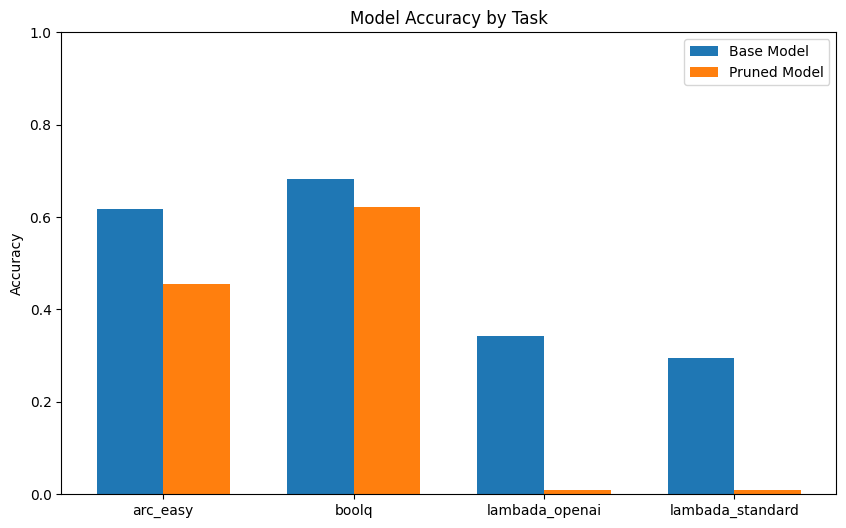

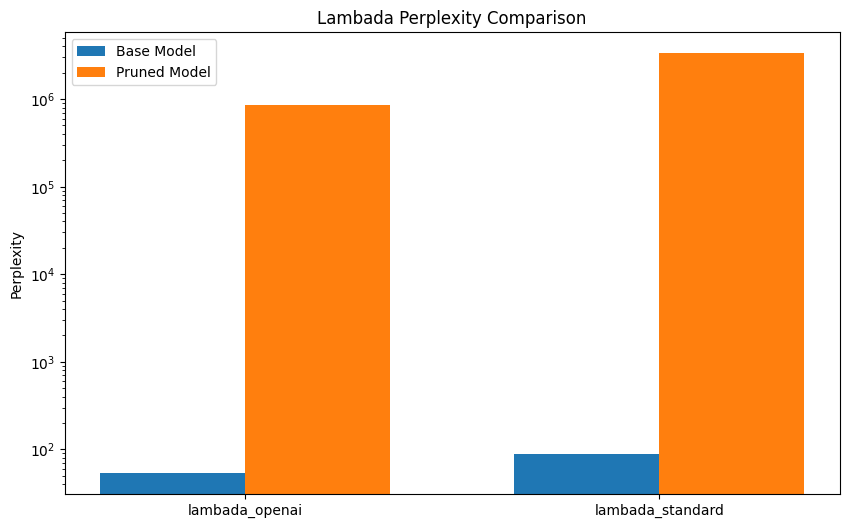

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy(metric_base1, metric_pruned1)
    """
    Plots a bar chart comparing the base and pruned model accuracies for each task.
    """
    # Get all tasks present in the base metrics dictionary
    tasks = list(metric_base1.keys())

    # Extract accuracies from both dictionaries (if available)
    accuracy_base = [metric_base1[task].get('acc,none', None) for task in tasks]
    accuracy_pruned = [metric_pruned1[task].get('acc,none', None) for task in tasks]

    # Create the bar plot
    x = np.arange(len(tasks))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, accuracy_base, width, label='Base Model')
    rects2 = ax.bar(x + width/2, accuracy_pruned, width, label='Pruned Model')

    ax.set_ylabel('Accuracy')
    ax.set_title('Model Accuracy by Task')
    ax.set_xticks(x)
    ax.set_xticklabels(tasks)
    ax.legend()
    ax.set_ylim(0, 1)  # Accuracy values are between 0 and 1

    plt.show()

def plot_perplexity(metric_base1, metric_pruned1):
    """
    Plots a bar chart comparing the base and pruned model perplexity for tasks that include a perplexity metric.
    The y-axis is on a logarithmic scale due to the wide range of perplexity values.
    """
    # Filter tasks that have a perplexity value in the base metrics
    lambada_tasks = [task for task in metric_base1 if 'perplexity,none' in metric_base1[task]]
    if not lambada_tasks:
        print("No perplexity metrics found to plot.")
        return

    perplexity_base = [metric_base1[task]['perplexity,none'] for task in lambada_tasks]
    perplexity_pruned = [metric_pruned1[task].get('perplexity,none', None) for task in lambada_tasks]

    x = np.arange(len(lambada_tasks))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, perplexity_base, width, label='Base Model')
    rects2 = ax.bar(x + width/2, perplexity_pruned, width, label='Pruned Model')

    ax.set_ylabel('Perplexity')
    ax.set_title('Lambada Perplexity Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(lambada_tasks)
    ax.legend()
    ax.set_yscale('log')  # Use a logarithmic scale

    plt.show()

def plot_metrics(metric_base1, metric_pruned1):
    """
    Calls the plotting functions for both accuracy and perplexity.
    """
    plot_accuracy(metric_base1, metric_pruned1)
    plot_perplexity(metric_base1, metric_pruned1)

if __name__ == "__main__":
    # Plot the metrics
    plot_metrics(metric_base, metric_pruned)


**Insights**:
**BoolQ**:
The performance drop for BoolQ is notable, with accuracy decreasing from 0.68 to 0.44. BoolQ is a dataset consisting of boolean (true/false) questions derived from reading comprehension. The fact that the pruned DeepSeek-R1-Distill-Qwen-1.5B model still retains some performance indicates that answering these types of questions requires relatively less complex reasoning, and fundamental language understanding remains somewhat intact despite pruning.

**Lambada** (OpenAI and Standard):
The drop in performance for Lambada OpenAI and Lambada Standard is drastic. The accuracy for Lambada OpenAI drops from 0.34 to 0.00, and for Lambada Standard, it also falls to 0.00. Moreover, the perplexity values have exploded to extremely high numbers. Lambada is a benchmark designed to evaluate the model’s ability to predict the final word in a passage, requiring deep contextual understanding and long-range coherence. The massive degradation suggests that pruning has removed crucial components responsible for tracking long-term dependencies and maintaining contextual coherence.

**ARC** Easy:
The ARC Easy benchmark experiences a severe performance drop, with accuracy decreasing from 0.61 to 0.25. ARC Easy is a reasoning-based benchmark that tests general knowledge and common-sense reasoning. The significant decline suggests that the removal of layers has weakened the model’s ability to establish logical connections between different pieces of knowledge, negatively impacting its ability to infer the correct answers.

**Conclusion:**
In this experiment, I examined the effects of depth pruning on the DeepSeek-R1-Distill-Qwen-1.5B model. Unlike width pruning, which requires explicit structural adjustments, depth pruning simplifies the approach but has notable consequences.

After pruning, the model exhibits severe degradation on tasks that require complex contextual reasoning and long-term coherence (e.g., Lambada, ARC Easy). However, its performance on BoolQ, a simpler reading comprehension task, while impacted, remains relatively more stable compared to other benchmarks. This suggests that pruning disproportionately affects the parts of the model that facilitate deep understanding and coherence, whereas simpler tasks that rely on fundamental language comprehension are less affected.

As highlighted in the paper: "What Matters in Transformers? Not All Attention is Needed" (arXiv:2406.15786), the most effective pruning strategy often involves removing the deepest layers of the model. However, as seen here, the extent of pruning has led to severe performance losses, especially in tasks requiring high-level reasoning and contextual awareness